In [49]:
import pandas as pd

# Load Dataset

In [50]:
df = pd.read_csv("datasets/dataset.csv")
columns = list(df.columns)
Y_columns = ["program_name", "optimal_luf", "loop_line_number"]
input_features = [x for x in columns if x not in Y_columns]
X = df[input_features]
Y = df["optimal_luf"]

features = set(X.columns)

# Filter

In [51]:
frequency = Y.value_counts()
print(frequency)

optimal_luf
1    71
4    33
8    32
3    27
5    27
6    25
2    22
7    10
Name: count, dtype: int64


In [52]:
Y = Y[Y.isin([1, 4, 8])]
Y_indices = list(Y.index)
X = X.loc[Y_indices]

frequency = Y.value_counts()
print(frequency)

optimal_luf
1    71
4    33
8    32
Name: count, dtype: int64


In [53]:
print(len(X))

136


# Train RF

In [54]:
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV as grid_search
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

## Feature Selection

In [55]:
stop = False
best_score = 0
best_gsv = None
scores = list()
best_features = set()

curr_features = set()

while len(curr_features) < 5:
    print("\n====================")
    
    col_to_add = None
    best_curr_score = 0
    best_cur_gsv = None

    for column_name in (features - curr_features):
        print(f"Testing {column_name}")
        X_filtered = X[list(curr_features.union({column_name}))]

        clf = RandomForestClassifier(class_weight='balanced')
        params = {
            'n_estimators':[50, 100, 200],
            'max_features':[2, 5],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        gsv = grid_search(clf, params, cv=5, n_jobs=-1, scoring='accuracy')
        gsv.fit(X_filtered, Y)

        if gsv.best_score_ > best_curr_score:
            best_curr_score = gsv.best_score_
            col_to_add = column_name
            best_cur_gsv = gsv
        
        print(f"Score: {gsv.best_score_}")

    if best_curr_score > best_score:
        best_score = best_curr_score
        best_gsv = best_cur_gsv
        curr_features.add(col_to_add)
        scores.append(best_curr_score)
        best_features = curr_features
        print(f"Found best!")
        print(f"Curr features: {curr_features}")
        print(f"Best score: {best_score}")

    elif abs(best_curr_score - best_score) >= 0.05:
        stop = True

    else:
        curr_features.add(col_to_add)
        scores.append(best_curr_score)
        print(f"Curr features: {curr_features}")
        print(f"Curr score: {best_curr_score}")
        print(f"Best score: {best_score}")



        



Testing array_accesses
Score: 0.3013227513227513
Testing intra_loop_dependencies_flow
Score: 0.43280423280423275
Testing inter_loop_dependencies
Score: 0.2936507936507936
Testing aluf
Score: 0.3592592592592593
Testing loop_nest_level
Score: 0.3455026455026455
Testing intra_loop_dependencies_anti
Score: 0.27936507936507937
Testing max_inter_loop_dependency_distance
Score: 0.44841269841269843
Testing max_inter_loop_dependency_distance_flow
Score: 0.521957671957672
Testing max_intra_loop_dependency_distance_flow
Score: 0.521957671957672
Testing other
Score: 0.3671957671957672
Testing max_intra_loop_dependency_distance_output
Score: 0.521957671957672
Testing inter_loop_dependencies_flow
Score: 0.521957671957672
Testing inter_loop_dependencies_output
Score: 0.36772486772486773
Testing has_inter_loop_carried_dependency
Score: 0.521957671957672
Testing max_intra_loop_dependency_distance_anti
Score: 0.521957671957672
Testing array_reads
Score: 0.31507936507936507
Testing intra_loop_dependenci

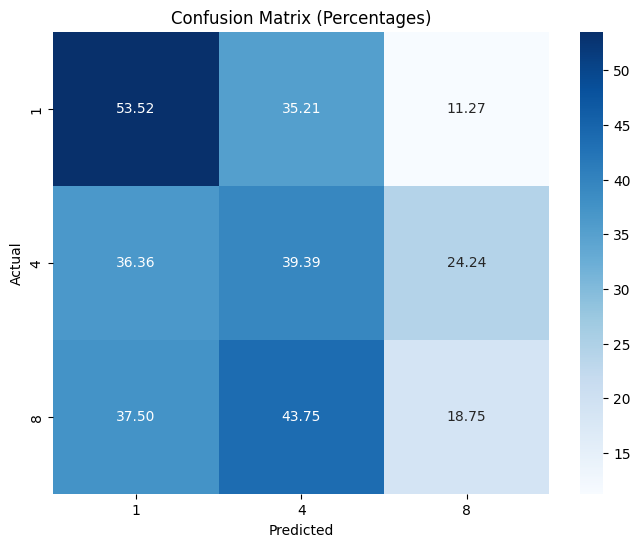

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cv_predictions = cross_val_predict(best_gsv.best_estimator_, X_filtered, Y, cv=5, n_jobs=-1)

# Create confusion matrix
cm = confusion_matrix(Y, cv_predictions)

# Convert to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

In [59]:
print(gsv.best_params_)
print(best_features)

{'max_depth': None, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
{'max_inter_loop_dependency_distance_flow', 'max_intra_loop_dependency_distance_flow', 'inter_loop_dependencies_anti', 'inter_loop_dependencies_flow', 'has_inter_loop_carried_dependency'}


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Acc1: {best_score}")
precision = precision_score(Y, cv_predictions, average='weighted')
recall = recall_score(Y, cv_predictions, average='weighted')
f1 = f1_score(Y, cv_predictions, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Acc1: 0.521957671957672
Precision: 0.4448044247024323
Recall: 0.41911764705882354
F1: 0.42482836271763597


In [ ]:
avg_err = 0
Y_list = list(Y)

for i in range(len(cv_predictions)):
    pred = cv_predictions[i]
    true = Y_list[i]
    avg_err += abs(pred-true)

avg_err /= len(cv_predictions)

print(f"Average error = {avg_err}")